In [1]:
# Core
import os
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn (still useful for train/test split + metrics)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report
)

# HuggingFace Transformers
from transformers import DistilBertTokenizerFast, DistilBertModel, DistilBertForSequenceClassification, Trainer, TrainingArguments

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import AdamW

# Progress bar
from tqdm import tqdm

# Warnings
import warnings
warnings.filterwarnings("ignore")


2025-09-03 14:01:18.683126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756908078.876835      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756908078.932118      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_and_clean_dataset_auto(file_path, spam_values=None, not_spam_values=None):
    """
    Automatically load and preprocess a dataset into ['text', 'label'] (0=ham, 1=spam).
    Detects text and label columns heuristically.
    Handles CSV encoding issues automatically.
    """
    # Detect extension
    ext = os.path.splitext(file_path)[-1].lower()

    # Load file
    if ext == ".csv":
        try:
            df = pd.read_csv(file_path, encoding="utf-8")
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding="latin1")
    elif ext in [".xls", ".xlsx"]:
        df = pd.read_excel(file_path)
    elif ext == ".json":
        try:
            df = pd.read_json(file_path, lines=True)
        except:
            df = pd.read_json(file_path)
    elif ext == ".txt":
        try:
            df = pd.read_csv(file_path, sep="\t", header=None, names=["text", "label"], engine="python", encoding="utf-8")
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, sep="\t", header=None, names=["text", "label"], engine="python", encoding="latin1")
    else:
        raise ValueError(f"Unsupported file format: {ext}")

    # Normalize column names
    df.columns = [str(c).lower() for c in df.columns]

    # Detect text column
    obj_cols = df.select_dtypes(include="object").columns.tolist()
    if obj_cols:
        text_col = df[obj_cols].apply(lambda x: x.str.len().mean()).idxmax()
    else:
        text_col = df.columns[0]

    # Detect label column
    possible_label_cols = [c for c in df.columns if c != text_col]
    if possible_label_cols:
        label_col = df[possible_label_cols].nunique().idxmin()
    else:
        label_col = df.columns[1] if len(df.columns) > 1 else df.columns[0]

    # Select and rename
    df = df[[text_col, label_col]].rename(columns={text_col: "text", label_col: "label"})
    df["text"] = df["text"].astype(str)

    # Default spam/ham values
    if spam_values is None:
        spam_values = ["spam", "1", 1, True, "yes", "true", "positive"]
    if not_spam_values is None:
        not_spam_values = ["ham", "0", 0, False, "no", "false", "negative", "not spam"]

    # Normalize labels
    df["label"] = df["label"].astype(str).str.lower().map(
        lambda x: 1 if x in [str(v).lower() for v in spam_values]
        else (0 if x in [str(v).lower() for v in not_spam_values] else None)
    )

    # Drop unknown labels
    df = df.dropna(subset=["label"])
    df["label"] = df["label"].astype(int)

    # Minimal cleaning (keep casing & symbols for BERT)
    df["text"] = df["text"].apply(lambda t: re.sub(r"\s+", " ", t).strip())

    return df.reset_index(drop=True)


In [3]:
# Auto-detecting function
df1 = load_and_clean_dataset_auto("/kaggle/input/email-spam-dedection/mail_data.csv")
df2 = load_and_clean_dataset_auto("/kaggle/input/email-spam-and-non-spam-datasets/mail_data.csv")
df3 = load_and_clean_dataset_auto("/kaggle/input/email-spam-classification-dataset-csv/emails.csv")
df4 = load_and_clean_dataset_auto("/kaggle/input/email-spam-detection-dataset-classification/spam.csv")
df5 = load_and_clean_dataset_auto("/kaggle/input/spam-email-classification/email.csv")
df6 = load_and_clean_dataset_auto("/kaggle/input/filtering-mobile-phone-spam/sms_spam.csv")
df7 = load_and_clean_dataset_auto("/kaggle/input/spamfilter/emails.csv")
df8 = load_and_clean_dataset_auto("/kaggle/input/sms-spam-collection-dataset/spam.csv")
df9 = load_and_clean_dataset_auto("/kaggle/input/spam-email/spam.csv")
df10 = load_and_clean_dataset_auto("/kaggle/input/spambase/spambase_csv.csv")
df11 = load_and_clean_dataset_auto("/kaggle/input/d/shalmamuji/spam-email-classification/email_classification_dataset.csv")
df12 = load_and_clean_dataset_auto("/kaggle/input/email-spam-classification-dataset/combined_data.csv")
df13 = load_and_clean_dataset_auto("/kaggle/input/spam-email-dataset/emails.csv")
df14 = load_and_clean_dataset_auto("/kaggle/input/spam-email-prediction/spambase.csv")
df15 = load_and_clean_dataset_auto("/kaggle/input/d/noeyislearning/spam-emails/emails.csv")
df16 = load_and_clean_dataset_auto("/kaggle/input/spam-emails/spam.csv")
df17 = load_and_clean_dataset_auto("/kaggle/input/spamemailsdataset/Spam.csv")
df18 = load_and_clean_dataset_auto("/kaggle/input/spam-filter/emails.csv")
df19 = load_and_clean_dataset_auto("/kaggle/input/spam-filter-dataset/spam.csv")
df20 = load_and_clean_dataset_auto("/kaggle/input/spam-mail-classifier-dataset/spam_mail_classifier.csv")
df21 = load_and_clean_dataset_auto("/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv")
df22 = load_and_clean_dataset_auto("/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv")
df23 = load_and_clean_dataset_auto("/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv")







In [4]:
# Merge into one dataset
final_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19, df20, df21, df22, df23], ignore_index=True)

print(final_df.head())
print(final_df["label"].value_counts())

                                                text  label
0  Go until jurong point, crazy.. Available only ...      0
1                      Ok lar... Joking wif u oni...      0
2  Free entry in 2 a wkly comp to win FA Cup fina...      1
3  U dun say so early hor... U c already then say...      0
4  Nah I don't think he goes to usf, he lives aro...      0
label
0    133908
1     66207
Name: count, dtype: int64


In [5]:
final_df.shape

(200115, 2)

In [6]:
final_df.isna().sum()

text     0
label    0
dtype: int64

In [7]:
final_df.duplicated().sum()

90352

In [8]:
final_df = final_df.drop_duplicates()

In [9]:
final_df.shape

(109763, 2)

In [10]:
final_dff = final_df.copy()

In [11]:
final_dff.sample(10)

,text,label
91223,attached is the eeos requirement list from dav...,0
138903,"shirley , i will take half day off tomorrow mo...",0
132466,his daily practice to escapenumberkeep under h...,1
190742,Subject: your paper has been invited at the ge...,1
192502,date thu NUMBER aug NUMBER NUMBER NUMBER NUMBE...,0
67962,i have a laptop averatec escapenumber i instal...,0
94299,make her wake up the neighbors your new 9 inch...,1
94791,trouble finding buddies develop problem solvin...,1
83216,"paul , i shall be in london in the beginning o...",0
82875,below please find the opinion of ena legal rel...,0


In [12]:


# Shuffle indices
indices = np.arange(len(final_dff))
np.random.shuffle(indices)

# Reserve 20% as hold-out
holdout_size = int(0.2 * len(final_dff))
holdout_idx = indices[:holdout_size]
train_idx   = indices[holdout_size:]

# Split into hidden test (hold-out) and training pool
df_holdout   = final_dff.iloc[holdout_idx]
df_train_all = final_dff.iloc[train_idx]


In [13]:
df_train_all.shape

(87811, 2)

Label counts:
 label
0    48773
1    39038
Name: count, dtype: int64


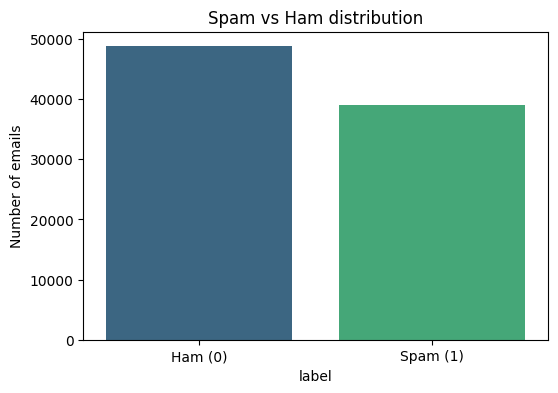

Percentage distribution:
 label
0    55.54
1    44.46
Name: count, dtype: float64


In [14]:


# Count of labels
label_counts = df_train_all['label'].value_counts()

print("Label counts:\n", label_counts)

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xticks([0,1], ['Ham (0)', 'Spam (1)'])
plt.ylabel("Number of emails")
plt.title("Spam vs Ham distribution")
plt.show()

# Optional: percentage
percentages = (label_counts / label_counts.sum() * 100).round(2)
print("Percentage distribution:\n", percentages)


In [15]:
import numpy as np

# Separate classes
df_ham = df_train_all[df_train_all['label'] == 0]
df_spam = df_train_all[df_train_all['label'] == 1]

# Find how many to duplicate
if len(df_ham) > len(df_spam):
    diff = len(df_ham) - len(df_spam)
    df_spam_oversampled = pd.concat([df_spam, df_spam.sample(diff, replace=True, random_state=42)])
    df_balanced = pd.concat([df_ham, df_spam_oversampled])
else:
    diff = len(df_spam) - len(df_ham)
    df_ham_oversampled = pd.concat([df_ham, df_ham.sample(diff, replace=True, random_state=42)])
    df_balanced = pd.concat([df_ham_oversampled, df_spam])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
new_counts = df_balanced['label'].value_counts()
new_percent = (new_counts / new_counts.sum() * 100).round(2)
print("Balanced label counts:\n", new_counts)
print("Balanced percentage distribution:\n", new_percent)


Balanced label counts:
 label
1    48773
0    48773
Name: count, dtype: int64
Balanced percentage distribution:
 label
1    50.0
0    50.0
Name: count, dtype: float64


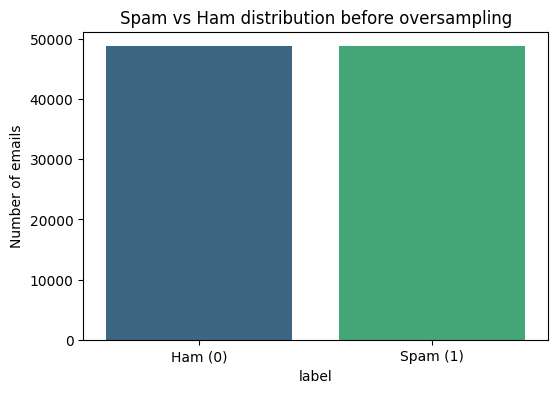

In [16]:
# Original label distribution
label_counts = df_balanced['label'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xticks([0,1], ['Ham (0)', 'Spam (1)'])
plt.ylabel("Number of emails")
plt.title("Spam vs Ham distribution before oversampling")
plt.show()


In [17]:
df_balanced.head(10)

,text,label
0,nice to meet you visit our new online drug sto...,1
1,trading escapelong for you su mbol chvccurrent...,1
2,hello your refinance application has been acce...,1
3,_ _ _____ _ __ the weekly high tech sarcastic ...,0
4,do something to help yourself - quit smoking i...,1
5,Subject: txu nom . s for 10 / 11 / 00 attached...,0
6,- you can get $ 100 worth hershey ? s ® chocol...,1
7,I thk 50 shd be ok he said plus minus 10.. Did...,0
8,"ben , i spoke with anjam and gave him the info...",0
9,on escapenumber escapenumber escapenumber yeho...,0


In [18]:
# Features and labels
X_text = df_balanced['text']
y = df_balanced['label']

# Split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train_text), "Test size:", len(X_test_text))


Train size: 78036 Test size: 19510


In [19]:
# ===============================
# Tokenization
# ===============================
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

X_train_enc = tokenizer(
    X_train_text.tolist(),
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="pt"
)

X_test_enc = tokenizer(
    X_test_text.tolist(),
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="pt"
)

print("Tokenization done. Train shape:", X_train_enc['input_ids'].shape)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenization done. Train shape: torch.Size([78036, 256])


In [20]:

# ===============================
# Dataset
# ===============================
class SpamDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

train_dataset = SpamDataset(X_train_enc, y_train.reset_index(drop=True))
test_dataset = SpamDataset(X_test_enc, y_test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [21]:
# ===============================
# Model
# ===============================
class DistilBERTClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(DistilBERTClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0]  # CLS token
        x = self.dropout(hidden_state)
        return self.fc(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBERTClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [22]:
# ===============================
# Training loop
# ===============================
for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        loop.set_description(f"Epoch {epoch+1}/{epochs}")
        loop.set_postfix(loss=loss.item())
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} finished | Average Loss = {avg_loss:.4f}")

Epoch 1/3: 100%|██████████| 4878/4878 [30:52<00:00,  2.63it/s, loss=0.0287]  


Epoch 1 finished | Average Loss = 0.0612


Epoch 2/3: 100%|██████████| 4878/4878 [30:56<00:00,  2.63it/s, loss=0.000384]


Epoch 2 finished | Average Loss = 0.0195


Epoch 3/3: 100%|██████████| 4878/4878 [30:58<00:00,  2.62it/s, loss=0.000294]

Epoch 3 finished | Average Loss = 0.0111


In [23]:
# Make sure model is in evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)  # Tensor of logits
        preds = torch.argmax(outputs, dim=1)        # Choose the class with highest score

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import accuracy_score
train_acc = accuracy_score(all_labels, all_preds)
print(f"Training Accuracy: {train_acc:.4f}")


Training Accuracy: 0.9981


In [25]:
import torch
import zipfile
import os

# Suppose `model` is your trained DistilBERT model
model_path = "/kaggle/working/distilbert_spam_classifier_full.pt"
torch.save(model, model_path)
print(f"Full model saved to {model_path}")

# Optional: zip it for easy download
zip_path = "/kaggle/working/distilbert_spam_classifier_full.zip"
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write(model_path, os.path.basename(model_path))

print(f"Zipped model saved to {zip_path}")


Full model saved to /kaggle/working/distilbert_spam_classifier_full.pt
Zipped model saved to /kaggle/working/distilbert_spam_classifier_full.zip


In [ ]:
from transformers import DistilBertForSequenceClassification

# Wrap your trained model into HuggingFace's class
hf_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)
hf_model.load_state_dict(model.state_dict())  # load your trained weights

# Save both model + tokenizer in one folder
hf_model.save_pretrained("distilbert_spam_classifier")
tokenizer.save_pretrained("distilbert_spam_classifier")


In [ ]:
import torch

# ✅ Save only the weights (state_dict)
save_path = "/kaggle/working/distilbert_spam_classifier_state_dict.pt"
torch.save(model.state_dict(), save_path)
print(f"Model state_dict saved to {save_path}")

# ✅ Save tokenizer separately
tokenizer.save_pretrained("/kaggle/working/distilbert_spam_tokenizer")
print("Tokenizer saved to /kaggle/working/distilbert_spam_tokenizer")


In [ ]:
import shutil
shutil.make_archive("/kaggle/working/distilbert_spam_classifier", 'zip', "/kaggle/working/distilbert_spam_classifier")


In [26]:
# ===============================
# Hold-out evaluation
# ===============================
X_holdout_text = df_holdout['text']
y_holdout = df_holdout['label'].values

X_holdout_enc = tokenizer(
    X_holdout_text.tolist(),
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="pt"
)

holdout_dataset = TensorDataset(
    X_holdout_enc['input_ids'],
    X_holdout_enc['attention_mask'],
    torch.tensor(y_holdout)
)
holdout_loader = DataLoader(holdout_dataset, batch_size=32)

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in holdout_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=['Ham', 'Spam']))


              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99     12138
        Spam       0.99      0.99      0.99      9814

    accuracy                           0.99     21952
   macro avg       0.99      0.99      0.99     21952
weighted avg       0.99      0.99      0.99     21952



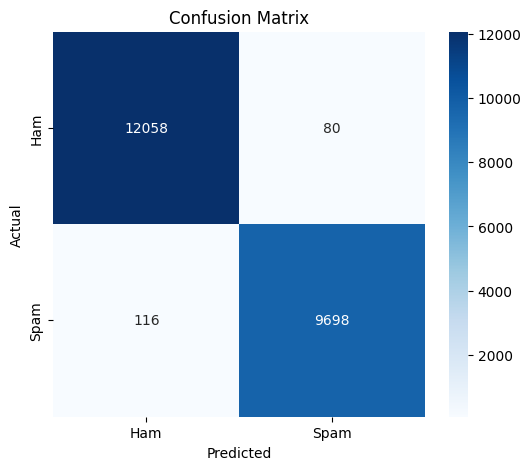

In [27]:
# ===============================
# Confusion matrix
# ===============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [29]:
import torch
import shutil
import os
from IPython.display import FileLink

# 1️⃣ Save full model to a folder
output_dir = "/kaggle/working/distilbert_spam_classifier"
os.makedirs(output_dir, exist_ok=True)

# Save the model
model_path = os.path.join(output_dir, "distilbert_spam_classifier_full.pt")
torch.save(model, model_path)

# Save the tokenizer
tokenizer_path = os.path.join(output_dir, "tokenizer")
os.makedirs(tokenizer_path, exist_ok=True)
tokenizer.save_pretrained(tokenizer_path)

# 2️⃣ Zip the folder
shutil.make_archive(output_dir, 'zip', output_dir)

# 3️⃣ Create clickable link
FileLink("distilbert_spam_classifier.zip")


/kaggle/working/distilbert_spam_classifier.zip